# Using unsupervised learning to predict Pitchfork reviews

Pitchfork.com, an online music blog known for its "hipster" taste in albums, is both obsessed over and reviled by audiophiles across the internet.

The site is notorious for its rating scale, which goes from 0 to 10 and can seem arbitrary at times. Pitchfork is also known for its Best New Music (BNM) designation, which at times seems to be disconnected from the score of the review, though typically it's only given to albums that score at least an 8.6.

![](./assets/cover2.jpg)

The question we posed is: is the BNM certification actually random? Can we use the words used by Pitchfork's team of flannel-wearing writers to determine whether an album is deemed as BNM by using unsupervised learning methods?

In [1]:
import re
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
from tqdm import tqdm
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.decomposition import PCA
import sklearn.feature_extraction.text as text
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns



#### Module-level functions and declarations

To scrape data from the reviews, we wrote a function that automatically takes relevant information from each review page. As a variable, the function takes an 'album' which in this case is a page accessed using bs(.content). From there, it searches for the relevant HTML tags to find the specific information for:
    
    - Album Title
    - Artist
    - Year
    - Genre
    - Whether an album is BNM or Best New Reissue
    - The album's score
    - The full text of the review

There are also rare instances where an artist will release a multi-album that shares a review. This requires its own function as the tags are different, as well as the need for try/except loops to determine which function to use when logging the albums.

Additionally, we also included functions for cleaning extracted text of leftover HTML tags and extended spaces, as well as one to stem sentence inputs.

In [2]:
from numpy import NaN

# Write function to scrape review pages

def get_album(album):

  info = []

  title = album.find('h1').text

  artist = album.find(class_="BaseWrap-sc-TURhJ BaseText-fFzBQt SplitScreenContentHeaderArtist-lgjmiI eTiIvU ifBumJ fUDxJr").text

  year = int(album.find(class_="SplitScreenContentHeaderReleaseYear-gTOUCD eEdlyG").text)
  genre = album.find(class_="BaseWrap-sc-TURhJ BaseText-fFzBQt InfoSliceValue-gSTMso eTiIvU bsGTGn glrVeB").text
  
  try:
    album.find(class_="BaseWrap-sc-TURhJ BaseText-fFzBQt BestNewMusicText-fzYpJx eTiIvU geimFR hKpSXa").text
  except AttributeError:
    bestnewmusic = 0
  else:
    bestnewmusic = 1
  
  if bestnewmusic == 1:
    score = float(album.find(class_='BaseWrap-sc-TURhJ BaseText-fFzBQt Rating-kkunXa eTiIvU geimFR dHIURZ').text)
  if bestnewmusic == 0:
    score = float(album.find(class_="BaseWrap-sc-TURhJ BaseText-fFzBQt Rating-kkunXa eTiIvU geimFR hVIWTS").text)

  abstract = album.find(class_="BaseWrap-sc-TURhJ BaseText-fFzBQt SplitScreenContentHeaderDekDown-fkIOvp eTiIvU ifBumJ etXaLE").text

  p1 = album.find(class_="body__inner-container").find('p', recursive=False).text
  p1 = p1.split('\xa0')
  p1 = p1[0]

  data = [title, artist, year, genre, score, bestnewmusic, abstract, p1]
  for i in data:
    info.append(i)
  
  return info



# function for rare instances of multi-album reviews
def get_multi_album(album):
  artist = album.find(class_="artist-links artist-list single-album-tombstone__artist-links").text

  scores = album.find_all(class_="score", text=True)
  scores_clean = cleantext(scores)

  titles = album.find_all(class_='single-album-tombstone__review-title')
  titles_clean = cleantext(titles)

  year = album.find(class_="single-album-tombstone__meta-year").text
  year = year.split(" ")
  year = int(year[2])

  genre = album.find(class_="genre-list__link").text

  bestnewmusic = []
  bnm = album.find_all(class_='single-album-tombstone')
  bnm_clean = cleantext_spaces(bnm)
  for b in range(len(bnm_clean)):
    check = bnm_clean[b].split("   ")
    if 'Best new reissue' in check or 'Best new music' in check:
      rates = 1
      bestnewmusic.append(rates)
    else:
      rates = 0
      bestnewmusic.append(rates)
  
  ab = album.find(class_="review-detail__abstract").text
  ab = ab.split('\n')
  abstract = ab[0]

  p1 = album.find(class_="contents dropcap").find('p', recursive=False).text
  p1 = p1.split('\xa0')
  p1 = p1[0]

  multi = []
  for i in range(len(scores_clean)):
    al = []
    al.append(titles_clean[i])
    al.append(artist)
    al.append(year)
    al.append(genre)
    al.append(float(scores_clean[i]))
    al.append(bestnewmusic[i])
    al.append(abstract)
    al.append(p1)
    multi.append(al)

  return multi


# Functions for html cleaning for find_all searches
def cleantext(html):
    text = [str(t) for t in html]
    
    clean = re.compile('<.*?>')
    
    clean_text = [re.sub(clean, '', t) for t in text]
    
    return clean_text


# function to clean text spaces
def cleantext_spaces(html):
    text = [str(t) for t in html]
    
    clean = re.compile('<.*?>')
    
    clean_text = [re.sub(clean, ' ', t) for t in text]
    
    return clean_text


# stem the sentence inputs
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


#### Download data and preprocess

To build the dataset, we first access Pitchfork's main review page, which lists all their most recent reviews 12 on a page. We use a for loop with the number of pages we wish to access, in this case 30, and extract the links to the album review pages and put them into a list. From there we use another for loop to run our get_album and get_multi_album functions to extract the information and add it as a row in our dataframe. This takes a while.

In [3]:
# Building full dataset
# This part takes a while to run :

# WARNING: Because this dataset is lifted directly from the website, running the program at 
# different times will result in different data sets as new reviews are put online.
# As such, some of the figures below in the analysis portion might be different than what the text says.

page_nums = list(range(1,30))

# get all albums
all_albums = pd.DataFrame()

for n in page_nums:
  
  q = requests.get(f'https://pitchfork.com/reviews/albums/?page={n}')
  revs = bs(q.content)
  
  reviews = revs.find_all('a',class_='review__link')
  links = [link['href'] for link in reviews]

  page_info = []
  
  for url in links:
    page = requests.get(f'http://pitchfork.com{url}')
    album = bs(page.content)

    try:
      al = get_album(album)
      page_info.append(al)
    except AttributeError:
      multi = get_multi_album(album)
      for i in range(len(multi)):
        page_info.append(multi[i])
 
  all_albums = all_albums.append(page_info, ignore_index=True)

An issue we ran into originally while creating our models was that our population of BNM albums was extremely low. In our 300-album dataset, only around 30 were classified as BNM, which made it difficult to create any kind of accuracy. While BNM is a rare honour, our challenge isn't to calculate the probability of BNM, but rather to see if we can use language to determine whether an album is BNM. As such, we need to run the loops again, this time only using BNM albums to create a more even dataset for our models to train on. This also takes a while.

In [5]:
# renaming columns
all_albums.columns = ['title', 'artist', 'year', 'genre', 'score', 'bestnewmusic', 'abstract', 'p1']

#dropping nulls:
all_albums.dropna(inplace=True)

# filter bestnewmusic = 0
no_bnm = all_albums.loc[all_albums.bestnewmusic == 0][:300]

# Generating BNM dataset
page_nums = list(range(1,26))

bnm_albums = pd.DataFrame()

for n in page_nums:
  
  q = requests.get(f'https://pitchfork.com/reviews/best/albums/?page={n}')
  revs = bs(q.content)
  
  reviews = revs.find_all('a',class_='review__link')
  links = [link['href'] for link in reviews]

  page_info = []
  
  for url in links:
    page = requests.get(f'http://pitchfork.com{url}')
    album = bs(page.content)

    try:
      al = get_album(album)
      page_info.append(al)
    except AttributeError:
      try:
        multi = get_multi_album(album)
        for i in range(len(multi)):
          page_info.append(multi[i])
      except AttributeError:
        continue
 
  bnm_albums = bnm_albums.append(page_info, ignore_index=True)

After some cleaning of the data, we now have a 600-album dataset that's half regular and half BNM.

In [6]:
# rename columns
bnm_albums.columns = ['title', 'artist', 'year', 'genre', 'score', 'bestnewmusic', 'abstract', 'p1']

# dropping nulls:
bnm_albums.dropna(inplace=True)

bnm_albums = bnm_albums[:300]

# merge no_bnm and bnm
mix = pd.concat([no_bnm, bnm_albums], ignore_index=True)

all_albums = mix.sample(frac=1, random_state=25)
all_albums.p1.dropna(inplace=True)

train_data = all_albums[['bestnewmusic', 'p1']]


# custom filter
all_albums.loc[(all_albums.genre == 'Joyful Noise')|(all_albums.genre == 'Nyege Nyege Tapes')|(all_albums.genre == 'Leaving')|(all_albums.genre == "You've Changed")
|(all_albums.genre == 'May 2, 2022')|(all_albums.genre == 'Rock Action')|(all_albums.genre == 'April 27, 2022')|(all_albums.genre == 'Pure Noise')|(all_albums.genre == "Bilna’es")
|(all_albums.genre == 'Last Gang')|(all_albums.genre == 'Other People / Unsound')|(all_albums.genre == 'Avian')] = NaN


test = [text for text in all_albums.p1]

#### Model Building

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
nltk.download('wordnet') #pre-trained models with a set of words
nltk.download('punkt') #has less words than wordnet

from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Prepare data for training

Here we are using a TfidfVectorizer, which transforms our text data into usable training data and assigns words values based on their frequency within the dataset. Words that are used less often will be given more importance than common words. For this, we'll only be using the album text and the BNM columns of our DataFrame, so all that work and time we spent getting the other info off the website was unfortunately wasted. Sorry!

In [8]:
tf = TfidfVectorizer()

# transform input data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(train_data['p1'])

#Term frequency, inverse document frequency, a measure of how relevant a word is to a document, give the words 
# different weights depending on importance and frequency

# set target label, what are we trying to predict? whether it is best new music or not.
y = train_data['bestnewmusic']


# get stemmed sentences,reduces the words to their root word. More helfup if there are spelling mistakes or messy slang 
#colloquialisms... 
# all_albums['preprocessing'] = all_albums['p1'].astype(str).apply(stemSentence)


# split dataset: one subset is the trained set, the other subset is the test set. ex: 80% is used to train, 
# 20% used to validate how well our model predicts
X_train, X_test, y_train, y_test = train_test_split(train_data['p1'], y, test_size=0.20, random_state=101)

# vectorize train-test: 1st vectorizer was on X, this one is on the x_train and x_test, which is generated from P1, 
#see line above
X_train = tf.fit_transform(X_train)  #fit_transform on training data
X_test = tf.transform(X_test)  

In [9]:
# run to see BNM vs NBNM
# y.hist()

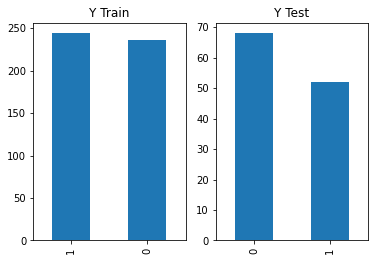

In [24]:
# Slight advantage for non-BNM albums in the test data

fig, (ax1, ax2) = plt.subplots(1, 2)
y_train.value_counts().plot(kind='bar', title = 'Y Train', ax = ax1)
y_test.value_counts().plot(kind='bar', title = 'Y Test', ax = ax2)
plt.show();

#### Pre-processing we could have done

The only pre-processing we did use is TFIDF (which measures weight of words) and PCA. TFIDF has a built-in list of English stop words (frequent words). We tried sentence stemming but that didn't work for us, could have been more useful for amateur writing: words 
with lots of errors for example.

Sentiment analysis would have been more useful for something like a Yelp review, because it's easier to predict based on certain factors, it's more sensational, the vocabulary is less advanced as opposed to reviewing an album which on this website seems to be more subjective and artistic.

Sentence embedding might have helped using the pre-trained models. It uses a pre-trained model using a dictionary of all the words that could be used. It then compares the words in the review to the words in the dict. With the dict, it creates a map and places the words from review into a catgeory in the map. We didn't use this because it would have required more data to run, and was potentially too complex.

We could have used more pre-processing but the writers are already professional, as opposed to a Reddit post for example. There is a random element to the BNM classification which makes it difficult to predict, so more pre-processing might not have helped us with the random aspect. 

#### Trying different models

We're using 5 different models to determine which method has the highest level of accuracy when determining whether an album is BNM:

- K-Means Clustering
- Logistic Regression
- Dimension Reduction
- Naive Baynes
- Support Vector Classifier

Model #1: K-Means

In [10]:
# model using K-Means of vectorized input

# We define the number of clusters #n_clusters =2, groups the reviews into the two clusters
# without knowing whether it's best new music or not.
# Model determines (unsupervised ) whether the 0(not best new music) or 1 (best new music) goes into which clusters
# Model will try to seperate the clusters (0,1 )evenly
# This is why it gives us an equal number in the dataset

# In the scatter  plot, instead of using a dict like it would in the sentence embedding, 
# it compares the existing words in the review only... to themselves. This is why sentence embedding could have helped.
 
model_kmeans = KMeans(n_clusters=2, random_state=29)
model_kmeans.fit(X)
metrics.fowlkes_mallows_score(y, model_kmeans.labels_)

0.5007021407286328

In [11]:
model_kmeans.fit(X_test)
y_pred=model_kmeans.labels_
metrics.fowlkes_mallows_score(y_test, y_pred)

0.5509336490450341

Model #2: Logistic Regression

In [12]:
log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train,y_train)           

preds = log_model.predict(X_test)

print(classification_report(y_test,preds,zero_division=1))

# primarily used on binary data sets
# precision for Logit Model was much higher before we had an evenly distributed data set of the albums
# that were best new music vs those that were not. Now that our data is correctly proportioned, the accuracy went from
# aprox 92% for 0 (NBNM) and went from 100% to 62% for 1s(BNM)

#Support group represents the number of albums in each logistic category (0,1), we have a sample size of 68 albums for 0s
# and we have 52 albums for the 1st

#F1 score : 'The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean'

#The score that matters most to us is precision. 
#Accuracy is for the macro average and weighted average. 
#From stack overflow : "Macro average gives each prediction similar 
# weight while calculating loss but there might be case when your data might be imbalanced and 
#you want to give importance to some prediction more (based on their proportion), there you use 'weighted' average. 

              precision    recall  f1-score   support

           0       0.66      0.65      0.65        68
           1       0.55      0.56      0.55        52

    accuracy                           0.61       120
   macro avg       0.60      0.60      0.60       120
weighted avg       0.61      0.61      0.61       120



Model #3: Dimension Reduction with PCA

In [13]:
# CS : Compressed size 

CS = 5
pca = PCA(n_components = CS)
pca_X = pca.fit(X_train.todense().T).components_.T

#todense takes the sparse matrix to a denser matrix, similarly to one hot enconding, the todense removes the extra zeros.
# and compresses the sparse matrix (A sparse matrix is a matrix that is comprised of mostly zero values.)
# (Sparse matrices are distinct from matrices with mostly non-zero values, 
# which are referred to as dense matrices. A matrix is sparse if many of its coefficients are zero.)

# split based on pca embeddings : similarly to how we compress big images, 
# we aee trying to compress into the principle variables, the most important features
# then we preform a split on the most reduced dimensions
#Reducing ( PCA) is a form of preprocessing

pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_X, y_train, test_size=0.20, random_state=101)

# fit pca embeddings to logit model
log_model.fit(pca_X_train, pca_y_train)        
predspc = log_model.predict(pca_X_test)

print(classification_report(pca_y_test, predspc,zero_division=1))


# CONCLUSION :
# After PCA, the precision scores have mildly (unnoticably) changed. BNM is now at 62% precision 
# and weighted average has increased by 2%, the F1 score is not much different. The results are likely slightly worse
# than just using the original log model, though not by much.


C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


              precision    recall  f1-score   support

           0       0.57      0.52      0.55        46
           1       0.59      0.64      0.62        50

    accuracy                           0.58        96
   macro avg       0.58      0.58      0.58        96
weighted avg       0.58      0.58      0.58        96



Model #4: Naive Bayes

In [14]:
# Not seen in class taken from the internet.

# Model that is normally applied to a normal distribution,
# We do not have a normal distribution but we have binomial distribution which has the same or similar shape to a binomial
# distribution,
# a normal distribution is like a bell-curve.
# Considering that this model would work with a distribution that presents itself similarly to our distribution
#I thought it would be interesting to give it a try.
# Applies Bayes Theorem ( looks at false negatives and false positives to make classifications - think of covid - )

gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
preds_gnb = gnb.predict(X_test.toarray())

#Determine accuracy score
accuracy_score(y_test, preds_gnb)

# CONCLUSION:

# This model would have been a better fit for a normal distribution despite it 
# taking in similar shapes of predictions and tagrtes/expected results

0.5833333333333334

Model #5: Support Vector Machines

In [15]:
sv = SVC(kernel='linear')
sv.fit(X_train, y_train)
preds_sv = sv.predict(X_test)

#Determine accuracy score
accuracy_score(y_test, preds_sv)

# Typically works with continuous values ( might have worked best with album score). 
# It is a supervised model, it uses classification algorithms and is specifically designed for 
# two group classification models. Which should work perfectly with our data set which is binary, also good at detecting outliar data points.
# The advantange of this model is that uses a subset a of training points in the decision function (the support vectors ), 
# which makes it memory efficient as opposed to decision trees or random forests which take up a lot of space.(memory intensive)
# According to the Scikit.learn documenation, this model is a gold standard and works with pretty-much everything,
# as opposed to our previous model (Naive-Bayes) which works predominantly with normal distribution.

0.625

#### Data Visualization

In [16]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "LogisiticRegression": LogisticRegression(),
    "KMeans": KMeans(),
    "Support Vector Classifier": SVC(),
    "PCA": PCA(),
}
cf_matrix = dict.fromkeys(classifiers.keys())

for key, classifier in classifiers.items():
    print(key)
    #cf_matrix[key]=confusion_matrix(y_test, y_p

Naive Bayes
LogisiticRegression
KMeans
Support Vector Classifier
PCA


One simple solution for comparing each model is through the use of confusion matricies. It provides an array that lists, clockwise: True Positives, False Positives, False Negatives and True Negatives. Using a heatmap gives us a quick way to determine which values are higher. Here, the Log Model and SVC have the highest levels of True positives and negatives, with Baynes not too far behind. K-means has a siginficant issue with False Positives while the PCA was a fairly even spread across all the categories.

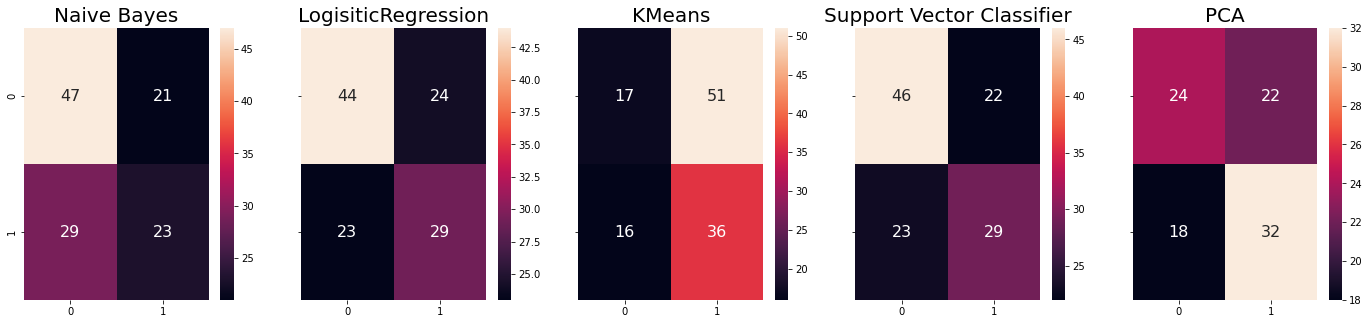

In [17]:

fig, ax = plt.subplots(1,5, sharex=True, sharey=True,figsize=(24,5))

sns.heatmap(confusion_matrix(y_test,preds_gnb),ax=ax[0], annot=True, annot_kws={"size": 16})
sns.heatmap(confusion_matrix(y_test,preds), ax=ax[1], annot=True, annot_kws={"size": 16})

sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[2], annot=True, annot_kws={"size": 16})

sns.heatmap(confusion_matrix(y_test,preds_sv),ax=ax[3], annot=True, annot_kws={"size": 16})

sns.heatmap(confusion_matrix(pca_y_test,predspc),ax=ax[4], annot=True, annot_kws={"size": 16})

for i, ax in enumerate(ax.flat):
    k = list(cf_matrix)[i]
    
    ax.set_title(k,fontsize=20)
plt.show()

Additonally, we can plot our K-Means cluster, as well as plot our models on a Receiver Operating Charistics (ROC) Curve, which displays the sensitivity and specificity of a logistic regression model. As a rule, the more the model hugs the top left of the frame, the better it is. We can also calculate the Area Under the Curve (AUC) which gives us a score of how much is under the curve. The closer it is to 1, the better the model.

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

auc_lr = roc_auc_score(y_test, preds)
auc_preds_gnb = roc_auc_score(y_test, preds_gnb)
auc_preds_sv = roc_auc_score(y_test, preds_sv)
auc_preds_km = roc_auc_score(y_test, y_pred)





fpr, tpr, _ = metrics.roc_curve(y_test,  preds)

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, preds_gnb)
fpr_sv, tpr_sv, thresholds_sv = roc_curve(y_test, preds_sv)

fpr_km, tpr_km, thresholds_km = roc_curve(y_test, y_pred)




C:\Users\matth\AppData\Local\Temp/ipykernel_23028/1460226411.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot([0,1],[0,1],'r--',color='blue')


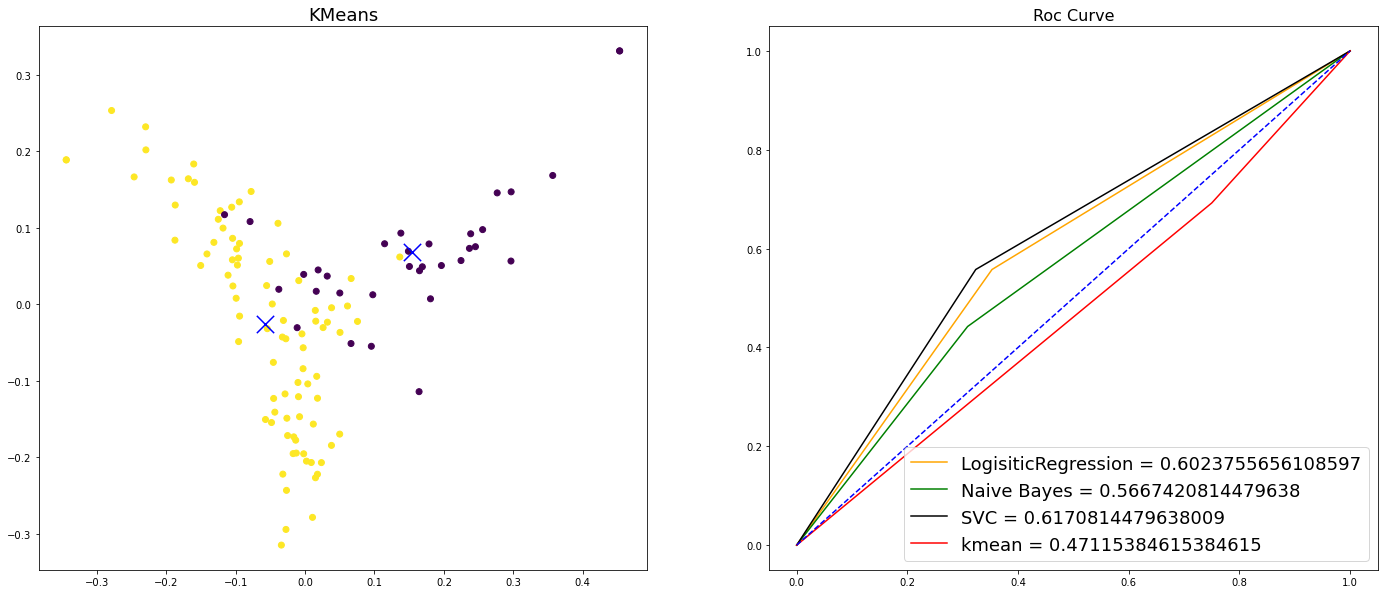

In [19]:

color = ['yellow' if c == 0 else 'red' for c in preds_sv]
color_gnb = ['blue' if c == 0 else 'orang' for c in preds_gnb]

reduced_features = pca.fit_transform(X_test.toarray())
reduced_cluster_centers = pca.transform(model_kmeans.cluster_centers_)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,10))
ax1.scatter(reduced_features[:,0], reduced_features[:,1], c=model_kmeans.predict(X_test))
ax1.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=300, c='b')
ax1.set_title('KMeans', fontsize=18)

ax2.plot(fpr,tpr,label="LogisiticRegression = "+str(auc_lr),color='orange')
ax2.plot(fpr_gnb,tpr_gnb,label="Naive Bayes = "+str(auc_preds_gnb),color='green')
ax2.plot(fpr_sv, tpr_sv,label="SVC = "+str(auc_preds_sv),color='black')
ax2.plot(fpr_km, tpr_km,label="kmean = "+str(auc_preds_km),color='red')

ax2.plot([0,1],[0,1],'r--',color='blue')

ax2.legend(loc=4, fontsize=18)
ax2.set_title('Roc Curve', fontsize=16)

plt.show();

### Conclusion and Questions

As can be seen in the ROC plot, none of the models we used had any particular success when it comes to predicting whether or not an album would be considered as Best New Music. Though no method fell below the halfway line, the normal Log Model and the SVC both emerged as the best models to use in this instance. 

Another challenge we encountered is that we would see large differences in accuracy using different random states. 

This leads to the question as to what can be done. It's possible that with a larger data set that we would see better results and less random variance. Though it's also a strong possibility that the writers at Pitchfork really are as impossible to predict as people say.